In [1]:
from re import split
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import the self-build blocks
%pwd
# from lightunet import LightUnet


'/home/qiao/dev/giao/works/detecting/segmentation/unet34'

In [3]:
print(torch.cuda.is_available())

True


In [4]:
path = Path('/home/qiao/dev/giao/data/Google2020')

path_img = path/'image/'
path_label = path/'mask'
codes = ['Background', 'Smoke', 'Flame_Spot', 'Cloud', 'Person']
path_img

Path('/home/qiao/dev/giao/data/Google2020/image')

In [5]:
fnames = get_image_files(path_img)
print(fnames[0])

/home/qiao/dev/giao/data/Google2020/image/0027.png


In [6]:
lbl_names = get_image_files(path_label)
print(lbl_names[0])

/home/qiao/dev/giao/data/Google2020/mask/0027.png


In [7]:
# img = Image.open(fnames[0])
# img.show()

In [8]:
# img = Image.open(lbl_names[0])
# img.show()

In [9]:
get_y_fn = lambda x: path_label/f'{x.name}'
defaults.use_cuda = True

In [10]:
dls = SegmentationDataLoaders.from_label_func(
    path_img,
    bs = 1,
    fnames = fnames,
    label_func = get_y_fn,
    codes = codes,
    item_tfms = [Resize((480, 640))],
    batch_tfms = [Normalize.from_stats(*imagenet_stats)],
)

In [11]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Background']

def acc_smoke(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    # mask = target
    return (input.argmax(dim = 1)[mask]==target[mask]).float().mean()

metrics = acc_smoke

In [12]:
learn = unet_learner(dls, models.resnet34, metrics = metrics,
                    self_attention=True)

/home/qiao/anaconda3/envs/dev/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/qiao/anaconda3/envs/dev/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
device = 'cuda'
learn.model.to(device)

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

SuggestedLRs(valley=6.30957365501672e-05)

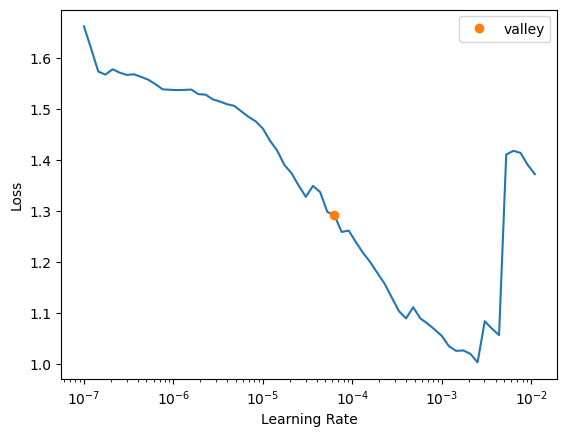

In [17]:
# learn.lr_find(stop_div=False, num_it=10)
learn.lr_find()

In [18]:
lr = 6.3e-5
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,acc_smoke,time
0,1.118864,0.652789,0.722267,00:08
1,0.831648,0.446081,0.768000,00:08
2,0.716704,0.403462,0.804737,00:08
3,0.629669,0.421136,0.832037,00:08
4,0.570584,0.408661,0.728651,00:08


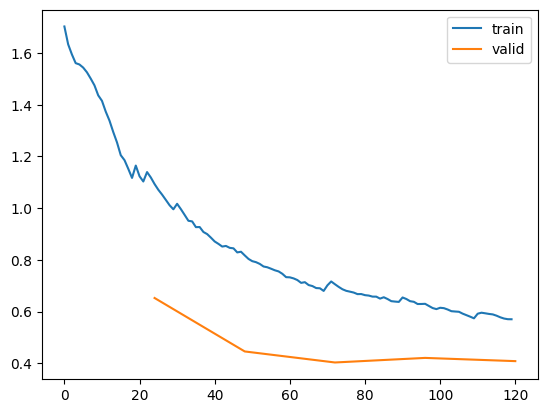

In [19]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

In [20]:
learn.save('stage-1_20230929')
learn.load('stage-1_20230929')

SuggestedLRs(valley=9.999999747378752e-06)

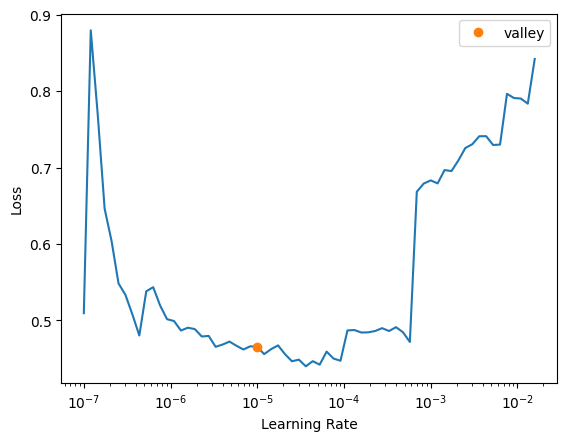

In [21]:
learn.unfreeze()
learn.lr_find()

In [22]:
lr_max = 9.9e-6

In [23]:
learn.fit_one_cycle(3, lr_max)

epoch,train_loss,valid_loss,acc_smoke,time
0,0.462086,0.421738,0.805572,00:09
1,0.448581,0.434740,0.768586,00:09
2,0.418351,0.430694,0.767955,00:09


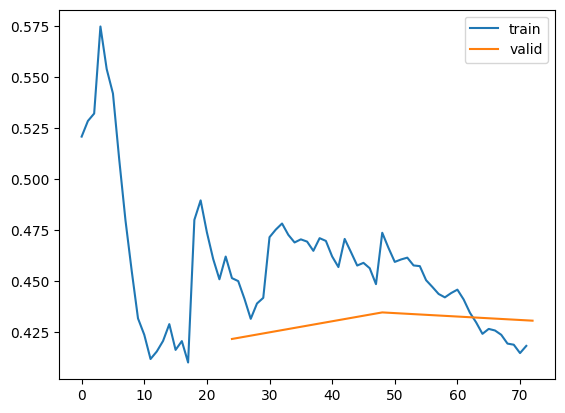

In [24]:
learn.recorder.plot_loss(skip_start=0, with_valid=True)

Path('/home/qiao/dev/giao/data/Google2020/image/models/AU-res34_20230929.pth')

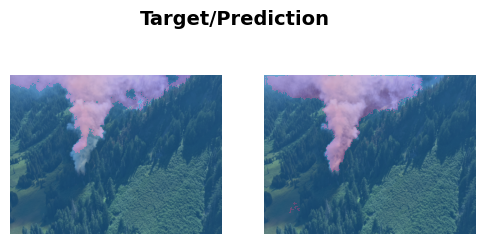

In [25]:
learn.show_results()
learn.save('AU-res34_20230929')

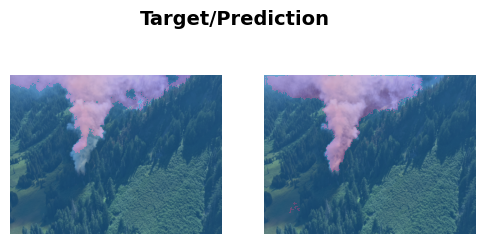

In [26]:
# learn.show_results()
learn.load('AU-res34_20230929')
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [ ]:
learn.show_results()

In [27]:
img = Image.open('/home/qiao/dev/giao/data/videos/20230926/frames/0000.png').resize((640, 480))
# img.show()

In [28]:
img = PILImage(img)

In [29]:
learn.load('AU-res34_20230929')
# learn.load('attunet')

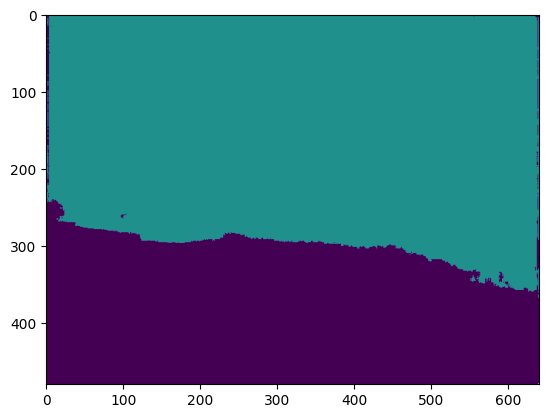

In [30]:
prediction_mask = learn.predict(img)
seg_map = prediction_mask[1]
torch.Tensor.ndim = property(lambda self: len(self.shape))
plt.imshow(seg_map)

In [31]:
import cv2
from numpy import asarray

<Axes: >

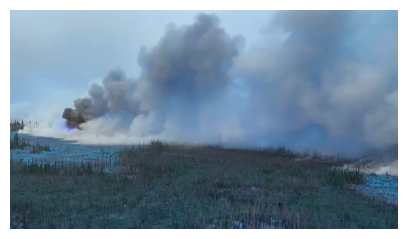

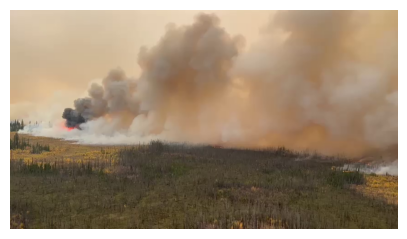

In [32]:
# single image cv2 imread test
img_sample_np = cv2.imread('/home/qiao/dev/giao/data/videos/20230926/frames/0000.png')
img = PILImage(Image.fromarray(img_sample_np))
img.show()
img_sample_np = cv2.cvtColor(img_sample_np, cv2.COLOR_BGR2RGB)
img = PILImage(Image.fromarray(img_sample_np))
img.show()

In [33]:
frame_path = '/home/qiao/dev/giao/data/videos/20230926/frames/*.png'
images = glob.glob(frame_path)
# The images need sort
images.sort()
print(images)

['/home/qiao/dev/giao/data/videos/20230926/frames/0000.png', '/home/qiao/dev/giao/data/videos/20230926/frames/0001.png', '/home/qiao/dev/giao/data/videos/20230926/frames/0002.png', '/home/qiao/dev/giao/data/videos/20230926/frames/0003.png', '/home/qiao/dev/giao/data/videos/20230926/frames/0004.png', '/home/qiao/dev/giao/data/videos/20230926/frames/0005.png', '/home/qiao/dev/giao/data/videos/20230926/frames/0006.png', '/home/qiao/dev/giao/data/videos/20230926/frames/0007.png', '/home/qiao/dev/giao/data/videos/20230926/frames/0008.png', '/home/qiao/dev/giao/data/videos/20230926/frames/0009.png', '/home/qiao/dev/giao/data/videos/20230926/frames/0010.png', '/home/qiao/dev/giao/data/videos/20230926/frames/0011.png', '/home/qiao/dev/giao/data/videos/20230926/frames/0012.png', '/home/qiao/dev/giao/data/videos/20230926/frames/0013.png', '/home/qiao/dev/giao/data/videos/20230926/frames/0014.png', '/home/qiao/dev/giao/data/videos/20230926/frames/0015.png', '/home/qiao/dev/giao/data/videos/202309

In [34]:
# images_np = [cv2.imread(file) for file in glob.glob('/home/qiao/dev/giao/data/videos/20230926/frames/*.png')]
images_np = [cv2.imread(file) for file in images]

In [35]:
# def draw_mask(image, mask_generated):
#     masked_image = image.copy()

#     masked_image = np.where(mask_generated.numpy().astype(int),
#                            np.array([0, 255, 0], type = 'uint8'),
#                            masked_image)
#     masked_image = masked_image.astype(np.uint8)

#     return cv2.addWeighted(image, 0.3, masked_image, 0.7, 0)

In [36]:
def overlay(image, mask, color, alpha, resize=None):
    """Combines image and its segmentation mask into a single image.
    https://www.kaggle.com/code/purplejester/showing-samples-with-segmentation-mask-overlay

    Params:
        image: Training image. np.ndarray,
        mask: Segmentation mask. np.ndarray,
        color: Color for segmentation mask rendering.  tuple[int, int, int] = (255, 0, 0)
        alpha: Segmentation mask's transparency. float = 0.5,
        resize: If provided, both image and its mask are resized before blending them together.
        tuple[int, int] = (1024, 1024))

    Returns:
        image_combined: The combined image. np.ndarray

    """
    color = color[::-1]
    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    colored_mask = np.moveaxis(colored_mask, 0, -1)
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()

    if resize is not None:
        image = cv2.resize(image.transpose(1, 2, 0), resize)
        image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)

    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)

    return image_combined

In [ ]:
# DONE: Need to covert from BGR2RGB
i = 0
for img_np in images_np:
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    img_np = cv2.resize(img_np, (640, 480))
    img = PILImage(Image.fromarray(img_np))
    prediction_mask = learn.predict(img)
    seg_map = prediction_mask[0]
    image_with_mask = np.copy(img)
    seg_result = overlay(image_with_mask, seg_map, color = [255, 0, 0], alpha = 0.3) 
    cv2.imwrite("/home/qiao/dev/giao/data/videos/20230926/AUNetruns/" + "%04d"%i + ".png", seg_result)
    i += 1

In [ ]:
import cv2
import numpy as np
import glob
from natsort import natsorted

img_array = []
filenames = natsorted(glob.glob('/home/qiao/dev/giao/data/videos/20230926/AUNetruns/*.png'))

# params for videowiriter output
video_name = '/home/qiao/dev/giao/data/videos/20230926/runs/20230926UNet_A.mp4'
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
fps = 30
frame_size = (640, 480)

for filename in filenames:                                    
    img = cv2.imread(filename)                                                                                           
    # height, width, layers = img.shape
    # size = (width, height)                                                                                               
    img_array.append(img)                                                                                                
# if store the .avi file, it need the fourcc of *'DIVX'                                                                  
out = cv2.VideoWriter(video_name, fourcc, fps, frame_size)                                                                                          
                                                                                                                         
for i in range(len(img_array)):                                                                                          
    out.write(img_array[i])                                                                                              
out.release()   